## Import libraries

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy
from scipy.integrate import quad
import pandas as pd
import seaborn as sns
import geopandas as gpd

## Load data

In [54]:
# We need the population of each region (only individuals aged 14 and over, since our event rates are referred to them)
# Year = 2012 - 2018
population_df = pd.read_csv('data/regions_population.csv')
population_df.drop(['ITTER107', 'TIPO_DATO15', 'Demographic data type', 'SEXISTAT1', 'Gender', 'ETA1', 'STATCIV2', 'Marital status', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)
# Group by year and region, summing the population in the different age range
population_df = population_df.groupby(['TIME', 'Territory']).sum()
population_df.reset_index(level=0, inplace=True)
population_df.reset_index(level=0, inplace=True)

# Merge Bolzano, Trento and Sudtirol
for year in population_df['TIME'].unique():
    bolzano = population_df.loc[(population_df['Territory'] == 'Provincia Autonoma Bolzano / Bozen') & (population_df['TIME'] == year)]['Value']
    trento = population_df.loc[(population_df['Territory'] == 'Provincia Autonoma Trento') & (population_df['TIME'] == year)]['Value']
    sudtirol = population_df.loc[(population_df['Territory'] == 'Trentino Alto Adige / Südtirol') & (population_df['TIME'] == year)]['Value']
    sum_trentino = bolzano.item() + trento.item() + sudtirol.item()
    population_df.loc[(population_df['Territory'] == 'Provincia Autonoma Trento') & (population_df['TIME'] == year), 'Value'] = sum_trentino
    population_df.loc[(population_df['Territory'] == 'Provincia Autonoma Trento') & (population_df['TIME'] == year), 'Territory'] = 'Trentino Alto Adige'

population_df = population_df.loc[~((population_df['Territory'] == 'Provincia Autonoma Bolzano / Bozen') | (population_df['Territory'] == 'Trentino Alto Adige / Südtirol')),:]
population_df.loc[(population_df['Territory'] == 'Valle d\'Aosta/Vallée d\'Aoste'), 'Territory'] = 'Valle d\'Aosta / Vallée d\'Aoste'

population_df.sort_values(by=['TIME', 'Value'], inplace=True)
population_df.head(20)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: `item` has been deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


,Territory,TIME,Value
20,Valle d'Aosta / Vallée d'Aoste,2012,109900
10,Molise,2012,277039
1,Basilicata,2012,506376
19,Umbria,2012,775290
5,Friuli-Venezia Giulia,2012,1073707
0,Abruzzo,2012,1148277
9,Marche,2012,1347974
7,Liguria,2012,1398250
15,Sardegna,2012,1451148
2,Calabria,2012,1701131


In [60]:
gdp = pd.read_csv('data/regions_gdp.csv', encoding = "ISO-8859-1")

# Remove space in Value
gdp['Value'] = gdp['Value'].apply(lambda x: x.replace(' ', ''))
gdp['Value'] = pd.to_numeric(gdp['Value'])

# Merge Bolzano and Trento
for year in gdp['TIME'].unique():
    bolzano = gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Bolzano/Bozen') & (gdp['TIME'] == year)]['Value']
    trento = gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Trento') & (gdp['TIME'] == year)]['Value']
    sum_trento_bolzano = bolzano.item() + trento.item()
    gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Trento') & (gdp['TIME'] == year), 'Value'] = sum_trento_bolzano
    gdp.loc[(gdp['GEO'] == 'Provincia Autonoma di Trento') & (gdp['TIME'] == year), 'GEO'] = 'Trentino Alto Adige'
    gdp = gdp.loc[~((gdp['GEO'] == 'Provincia Autonoma di Bolzano/Bozen') & (gdp['TIME'] == year)),:]

gdp.loc[(gdp['GEO'] == 'Valle d\'Aosta/Vallée d\'Aoste'), 'GEO'] = 'Valle d\'Aosta / Vallée d\'Aoste'

# Compute the GDP per capita
# Remove data of 2010-2011 since we do not have the population data for those years
gdp = gdp.loc[~(gdp['TIME'] == 2010),:]
gdp = gdp.loc[~(gdp['TIME'] == 2011),:]

for year in gdp['TIME'].unique():
    for region in gdp['GEO'].unique():
        pop_value = population_df.loc[(population_df['TIME'] == year) & (population_df['Territory'] == region)]['Value'].item()
        current_gdp = gdp.loc[(gdp['TIME'] == year) & (gdp['GEO'] == region)]['Value'].item()
        gdp.loc[(gdp['TIME'] == year) & (gdp['GEO'] == region), 'Value'] = (current_gdp * 1000000) / pop_value

# The unit of measure is now "euro"
gdp['UNIT'] = gdp['UNIT'].apply(lambda x: x.replace('Million euro', 'euro'))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `item` has been deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: `item` has been deprecated and will be removed in a future version
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: `item` has been deprecated and will be removed in a future version


In [61]:
df = pd.read_csv('data/public_auth_interactions.csv')
df.drop(['ITTER107', 'TIPO_DATO_SDS_ICT', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# Delete rows with year = 2019, since we do not have the GDP data for that year
df = df.loc[~(df['TIME'] == 2019),:]
# Delete rows with year = 2010-2011, since we do not have the population data for those years
df = df.loc[~(df['TIME'] == 2010),:]
df = df.loc[~(df['TIME'] == 2011),:]

# Merge Bolzano, Trento and Sudtirol
for year in df['TIME'].unique():
    for data_type in df['Data type'].unique():
        sudtirol_exp = df.loc[(df['Territory'] == 'Trentino Alto Adige / Südtirol') & (df['TIME'] == year) & (df['Data type'] == data_type)]['Value']
        bolzano_exp = df.loc[(df['Territory'] == 'Provincia Autonoma Bolzano / Bozen') & (df['TIME'] == year) & (df['Data type'] == data_type)]['Value']
        trento_exp = df.loc[(df['Territory'] == 'Provincia Autonoma Trento') & (df['TIME'] == year) & (df['Data type'] == data_type)]['Value']
        avg_exp = (float(sudtirol_exp.item()) + float(bolzano_exp.item()) + float(trento_exp.item())) / 3
        df.loc[(df['Territory'] == 'Trentino Alto Adige / Südtirol') & (df['TIME'] == year) & (df['Data type'] == data_type), 'Value'] = avg_exp
        df.loc[(df['Territory'] == 'Trentino Alto Adige / Südtirol') & (df['TIME'] == year) & (df['Data type'] == data_type), 'Territory'] = 'Trentino Alto Adige'
        df = df.loc[~(((df['Territory'] == 'Provincia Autonoma Bolzano / Bozen')) & (df['TIME'] == year) & (df['Data type'] == data_type)),:]
        df = df.loc[~(((df['Territory'] == 'Provincia Autonoma Trento')) & (df['TIME'] == year) & (df['Data type'] == data_type)),:]

df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: `item` has been deprecated and will be removed in a future version
  app.launch_new_instance()


,Territory,Data type,TIME,Value
2,Piemonte,obtaining information,2012,30.3
3,Piemonte,obtaining information,2013,26.1
4,Piemonte,obtaining information,2014,32.4
5,Piemonte,obtaining information,2015,33.0
6,Piemonte,obtaining information,2016,31.2


## Plot the "default" graphs

In [4]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

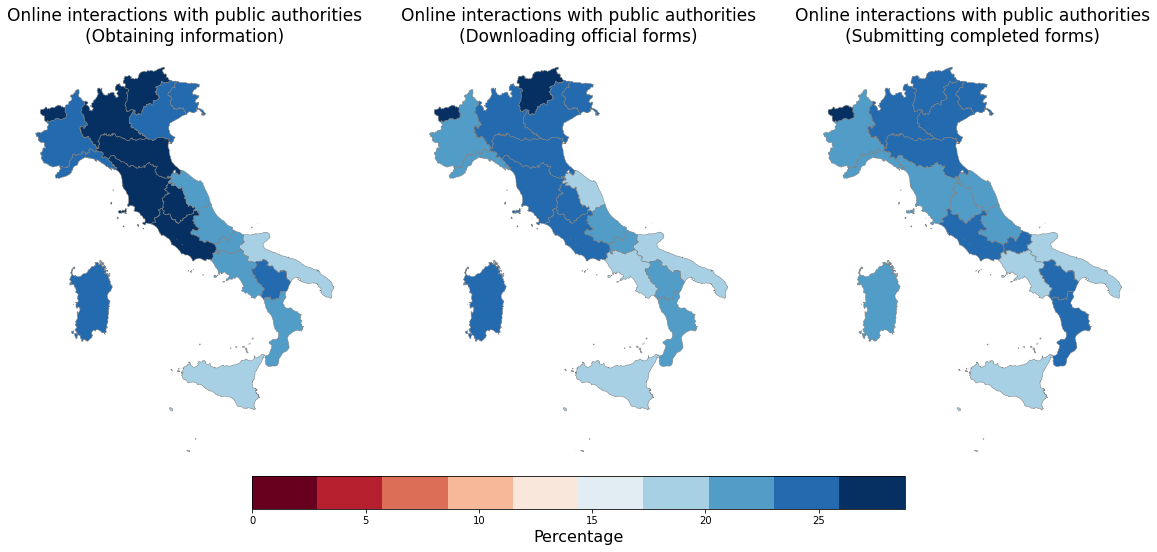

In [68]:
# Filter by year: keep only the 2018 data for each one of the 3 data types
filtered_df_1 = df.loc[(df['TIME'] == 2018) & (df['Data type'] == 'obtaining information'),:]
filtered_df_2 = df.loc[(df['TIME'] == 2018) & (df['Data type'] == 'downloading official forms'),:]
filtered_df_3 = df.loc[(df['TIME'] == 2018) & (df['Data type'] == 'submitting completed forms'),:]

map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})

# Merge the map with the pandas dfs
default_df_1 = pd.merge(map_reg, filtered_df_1, left_on='DEN_REG', right_on='Territory', how='left')
default_df_2 = pd.merge(map_reg, filtered_df_2, left_on='DEN_REG', right_on='Territory', how='left')
default_df_3 = pd.merge(map_reg, filtered_df_3, left_on='DEN_REG', right_on='Territory', how='left')

cmap = discrete_cmap(10, 'RdBu')

fig, ax = plt.subplots(ncols=3, figsize=(20, 10))

ax[0].axis('off')
ax[0].set_title('Online interactions with public authorities\n(Obtaining information)', fontsize=17)
default_df_1.plot(column='Value', vmin=0, vmax=max(default_df_1['Value']), cmap=cmap, linewidth=0.5, ax=ax[0], edgecolor='0.5')

ax[1].axis('off')
ax[1].set_title('Online interactions with public authorities\n(Downloading official forms)', fontsize=17)
default_df_2.plot(column='Value', vmin=0, vmax=max(default_df_2['Value']), cmap=cmap, linewidth=0.5, ax=ax[1], edgecolor='0.5')

ax[2].axis('off')
ax[2].set_title('Online interactions with public authorities\n(Submitting completed forms)', fontsize=17)
default_df_3.plot(column='Value', vmin=0, vmax=max(default_df_3['Value']), cmap=cmap, linewidth=0.5, ax=ax[2], edgecolor='0.5')

# Common colorbar
max_value = max(max(default_df_1['Value']), max(default_df_2['Value']), max(default_df_3['Value']))
norm = colors.Normalize(vmin=0, vmax=max_value)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation="horizontal", fraction=0.06, pad=0.01)
cbar.set_label('Percentage', fontsize=16)

In [14]:
fig.savefig('img/public_auth/default_graphs.png')

## Compute the surprise data

In [62]:
# Create one matrix for each 'data type' (3 in our case)
surprise_data = [[] for _ in range(len(df['Data type'].unique()))]
for j, data_type in enumerate(df['Data type'].unique()):
    for index, region in enumerate(df['Territory'].unique()):
        surprise_data[j].append([])
        for _ in range(len(df['TIME'].unique())): 
            surprise_data[j][index].append(0)

In [63]:
surprise_data

[[[0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0]]

Start with equiprobably P(M)s

For each year:

- Calculate observed-expected
- Estimate P(D|M)
- Estimate P(M|D)
- Surprise is D_KL ( P(M|D) || P(M) )
- Normalize so sum P(M)s = 1

For now, let's use only one model. We have to include inside our prior the economic status of the regions: an idea could be to take the GDP of each region and assume that the higher the GDP the higher the interaction with the public authorities. More precisely, we can assume that the highest GDP will correspond to the highest rate of interaction, and so on...

In [77]:
# Since we have only one model...
pM = 1

for i, data_type in enumerate(df['Data type'].unique()):
    
    pM = 1
    
    for k, year in enumerate(df['TIME'].unique()):
        # Compute the average rate of the current year
        avg_rate = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == data_type)]['Value'])
        # Compute the sum of the rates of the current year
        sum_rate = np.sum(df.loc[(df['TIME'] == year) & (df['Data type'] == data_type)]['Value'])

        # Get the list of regions ordered by GDP of the current year
        current_gdp = gdp.loc[gdp['TIME'] == year].sort_values(by=['Value'], ascending=False)

        for j, region in enumerate(df['Territory'].unique()):
            # Estimate P(D|M) as 1 - |O - E|
            O = (df.loc[(df['TIME'] == year) & (df['Territory'] == region) & (df['Data type'] == data_type)]['Value'] / sum_rate).item()
            # Get the region with the highest GDP in the current year
            highest_gdp = gdp.loc[gdp['TIME'] == year].max()['GEO']
            # Get the index of the current region in the ordered GDP list
            index = list(current_gdp['GEO']).index(region)
            # Get the current data observed and sort them
            obs_data = df.loc[(df['TIME'] == year) & (df['Data type'] == data_type)]
            obs_data.sort_values(by=['Value'], ascending=False, inplace=True)
            # Get the expected value
            E = (obs_data.iloc[index]['Value'] / sum_rate).item()

            # P(D|M)
            pDM = 1 - np.abs(O - E)

            # Estimate P(M|D)
            pMD = pDM * pM

            # Surprise is the sum of KL divergance across model space (only one here)
            kl = pMD * (np.log(pMD / pM) / np.log(2))
            surprise_data[i][j][k] = np.abs(kl) if (O - E) > 0 else -np.abs(kl)

        # Now let's globally update our model belief
        if k % 2 == 0:
            pDM = 1 - (0.5 * np.abs(O - E))
            pMD = pDM * pM
            pM = pMD

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `item` has been deprecated and will be removed in a future version
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Plot the results

In [78]:
# Starting from the surprise data, create the 3 dataframes
df_structure_1 = {}
df_structure_2 = {}
df_structure_3 = {}
for region in df['Territory'].unique():
    df_structure_1[region] = []
    df_structure_2[region] = []
    df_structure_3[region] = []
for index, region in enumerate(df_structure_1):
    df_structure_1[region] = surprise_data[0][index]
    df_structure_2[region] = surprise_data[1][index]
    df_structure_3[region] = surprise_data[2][index]

surprise_df_1 = pd.DataFrame(df_structure_1).transpose()
surprise_df_1.index.name = 'Territory'
surprise_df_1.columns = [str(year) for year in df['TIME'].unique()]

surprise_df_2 = pd.DataFrame(df_structure_2).transpose()
surprise_df_2.index.name = 'Territory'
surprise_df_2.columns = [str(year) for year in df['TIME'].unique()]

surprise_df_3 = pd.DataFrame(df_structure_3).transpose()
surprise_df_3.index.name = 'Territory'
surprise_df_3.columns = [str(year) for year in df['TIME'].unique()]

In [79]:
surprise_df_1.head(20)

,2012,2013,2014,2015,2016,2017,2018
Territory,,,,,,,
Piemonte,0.002296,-0.012183,0.003398,0.008394,0.008824,-0.002771,-0.004016
Valle d'Aosta / Vallée d'Aoste,-0.005606,-0.010919,-0.016430,0.008641,0.010245,-0.005260,-0.001723
Liguria,-0.014732,-0.014456,-0.015228,-0.007163,-0.012286,-0.003877,-0.007163
Lombardia,-0.018517,-0.001019,-0.009205,-0.008641,-0.017329,-0.009123,-0.003729
Trentino Alto Adige,0.017172,0.017396,0.012822,0.015841,0.020945,0.014714,0.016374
Veneto,-0.001276,0.001529,-0.003883,-0.004779,-0.000000,0.005168,-0.006306
Friuli-Venezia Giulia,0.018769,0.015717,0.009929,0.005931,0.008291,0.012700,-0.000000
Emilia-Romagna,-0.005860,-0.007627,-0.012581,-0.008394,-0.012020,0.001109,0.000479
Toscana,-0.005606,-0.002038,0.007756,0.003957,0.001073,0.000277,0.004302


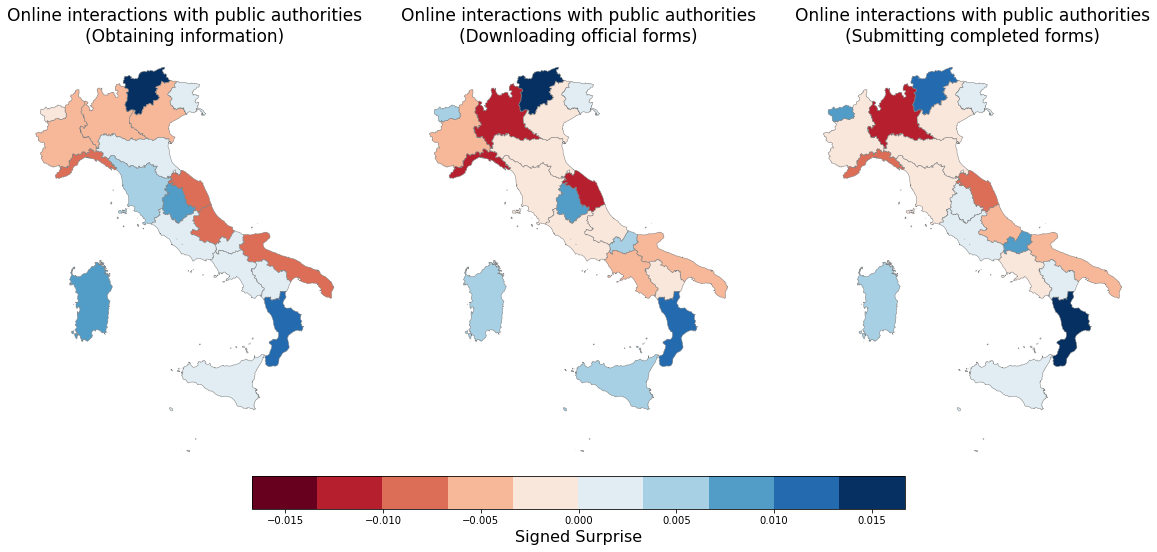

In [76]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})

# Merge the map with the pandas dfs
merged_1 = pd.merge(map_reg, surprise_df_1, left_on='DEN_REG', right_on='Territory', how='left')
merged_2 = pd.merge(map_reg, surprise_df_2, left_on='DEN_REG', right_on='Territory', how='left')
merged_3 = pd.merge(map_reg, surprise_df_3, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2018'
cmap = discrete_cmap(10, 'RdBu')
max_abs_value_1 = max(np.abs(min(merged_1[YEAR])), np.abs(max(merged_1[YEAR])))
max_abs_value_2 = max(np.abs(min(merged_2[YEAR])), np.abs(max(merged_2[YEAR])))
max_abs_value_3 = max(np.abs(min(merged_3[YEAR])), np.abs(max(merged_3[YEAR])))
max_value = max(max_abs_value_1, max_abs_value_2, max_abs_value_3)

fig, ax = plt.subplots(ncols=3, figsize=(20, 10))

ax[0].axis('off')
ax[0].set_title('Online interactions with public authorities\n(Obtaining information)', fontsize=17)
merged_1.plot(column=YEAR, vmin=-max_value, vmax=max_value, cmap=cmap, linewidth=0.5, ax=ax[0], edgecolor='0.5')

ax[1].axis('off')
ax[1].set_title('Online interactions with public authorities\n(Downloading official forms)', fontsize=17)
merged_2.plot(column=YEAR, vmin=-max_value, vmax=max_value, cmap=cmap, linewidth=0.5, ax=ax[1], edgecolor='0.5')

ax[2].axis('off')
ax[2].set_title('Online interactions with public authorities\n(Submitting completed forms)', fontsize=17)
merged_3.plot(column=YEAR, vmin=-max_value, vmax=max_value, cmap=cmap, linewidth=0.5, ax=ax[2], edgecolor='0.5')

# Common colorbar
norm = colors.Normalize(vmin=-max_value, vmax=max_value)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation="horizontal", fraction=0.06, pad=0.01)
cbar.set_label('Signed Surprise', fontsize=16)

In [81]:
fig.savefig('img/public_auth/surprise_baserate.png', bbox_inches='tight')

## Funnel Plot

In [16]:
def get_z_scores(year, data_type):
    tmp_df = df.loc[(df['TIME'] == year) & (df['Data type'] == data_type),:]
    z_scores = []
    x_bar = np.mean(tmp_df['Value']) / 100
    for region in population_df['Territory'].unique():
        O_s = tmp_df.loc[tmp_df['Territory'] == region]['Value'].item() / 100
        n = population_df.loc[(population_df['Territory'] == region) & (population_df['TIME'] == year)]['Value'].item()
        SE_s = (np.std(tmp_df['Value']) / 100) / np.sqrt(n)
        z_scores.append((region, (O_s - x_bar) / SE_s))
    z_score_values = [z_score[1] for z_score in z_scores]
    return z_scores, z_score_values

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys


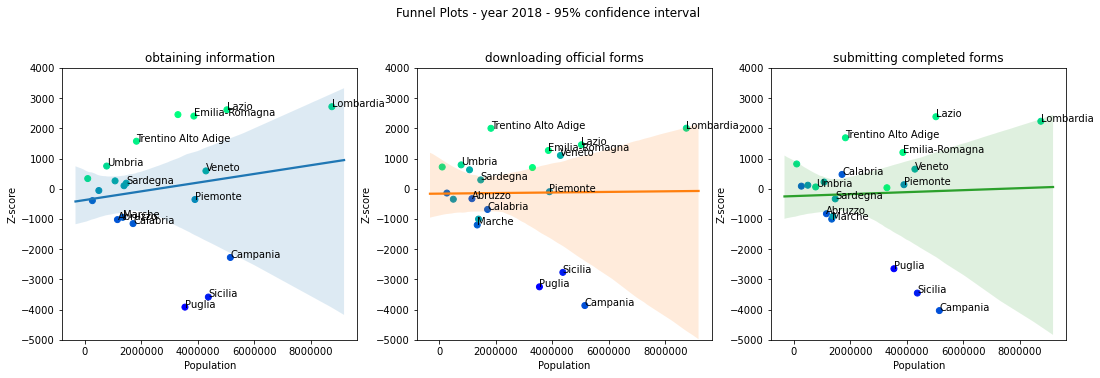

In [36]:
# Now we can compute the Z-scores of each region and then plot the funnel
YEAR = 2018

funnel_df = df.loc[(df['TIME'] == YEAR),:]
current_population_df = population_df.loc[population_df['TIME'] == YEAR]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Funnel Plots - year 2018 - 95% confidence interval", y=1.05)
# Plotting
for j, data_type in enumerate(funnel_df['Data type'].unique()):
    z_scores, z_score_values = get_z_scores(YEAR, data_type)
    ax[j].get_xaxis().get_major_formatter().set_scientific(False)
    ax[j].scatter(list(current_population_df['Value']), z_score_values, c=obs, cmap='winter')
    ax[j].set(xlabel='Population', ylabel='Z-score', title=data_type, ylim=(-5000, 4000))
    # Exclude some regions to avoid overlapping
    exclude_regions = ['Valle d\'Aosta / Vallée d\'Aoste', 'Friuli-Venezia Giulia', 'Basilicata', 'Molise', 'Liguria', 'Toscana']
    for i, text in enumerate([z_score[0] for z_score in z_scores]):
        if text not in exclude_regions:
            ax[j].annotate(text, (list(current_population_df['Value'])[i], z_score_values[i]))
    sns.regplot(list(current_population_df['Value']), z_score_values, ax=ax[j], scatter=False)

In [38]:
fig.savefig('img/public_auth/funnel_plots_2018.png', bbox_inches='tight')

In [39]:
def normal_distribution_function(z_score, mean, std):
    value = scipy.stats.norm.pdf(z_score, mean, std)
    return value

In [40]:
surprise_data_demoivre = [[] for _ in range(len(df['Data type'].unique()))]
for j, data_type in enumerate(df['Data type'].unique()):
    for index, region in enumerate(df['Territory'].unique()):
        surprise_data_demoivre[j].append([])
        for _ in range(len(df['TIME'].unique())): 
            surprise_data_demoivre[j][index].append(0)

In [41]:
# Since we have only one model...
pM = 1

for i, data_type in enumerate(df['Data type'].unique()):
    
    pM = 1

    for k, year in enumerate(df['TIME'].unique()):
        
        likelihoods = []
        mean = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == data_type)]['Value']) / 100
        _, current_z_scores = get_z_scores(year, data_type)
        z_mean = np.mean(current_z_scores)
        z_std = np.std(current_z_scores)
        
        for j, region in enumerate(df['Territory'].unique()):
            
            O = (df.loc[(df['TIME'] == year) & (df['Territory'] == region) & (df['Data type'] == data_type)]['Value']).item() / 100
            n = population_df.loc[(population_df['Territory'] == region) & (population_df['TIME'] == year)]['Value'].item()
            std = (np.std(df.loc[(df['TIME'] == year) & (df['Data type'] == data_type)]['Value']) / 100) / np.sqrt(n)
            # Compute the Z-score
            z_score = (O - mean) / std
            # Integrate to find the probability
            if z_score >= 0:
                res, err = quad(normal_distribution_function, 0, z_score, args=(z_mean, z_std))
                E = 1 - res
            else:
                res, err = quad(normal_distribution_function, -z_score, 0, args=(z_mean, z_std))
                E = np.abs(res)
            
            #print('region: ', region)
            #print('integral: ', res)
            
            # Get the expected value
            #E = (1 - 2 * res)
            
            likelihoods.append(E)
            
            # P(D|M)
            pDM = E

            # Estimate P(M|D)
            pMD = pDM * pM

            # Surprise is the sum of KL divergance across model space (only one here)
            kl = pMD * (np.log(pMD / pM) / np.log(2))
            surprise_data_demoivre[i][j][k] = np.abs(kl) if (z_score) > 0 else -np.abs(kl)
    
        # Now let's globally update our model belief
        if k % 2 == 0:
            pDM = (1 / len(df['Territory'].unique())) * sum(likelihoods)
            pMD = pDM * pM
            pM = pMD

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `item` has been deprecated and will be removed in a future version
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `item` has been deprecated and will be removed in a future version


### Plot the results

In [42]:
# Starting from the surprise data, create the 3 dataframes
df_structure_1 = {}
df_structure_2 = {}
df_structure_3 = {}
for region in df['Territory'].unique():
    df_structure_1[region] = []
    df_structure_2[region] = []
    df_structure_3[region] = []
for index, region in enumerate(df_structure_1):
    df_structure_1[region] = surprise_data_demoivre[0][index]
    df_structure_2[region] = surprise_data_demoivre[1][index]
    df_structure_3[region] = surprise_data_demoivre[2][index]

surprise_df_1 = pd.DataFrame(df_structure_1).transpose()
surprise_df_1.index.name = 'Territory'
surprise_df_1.columns = [str(year) for year in df['TIME'].unique()]

surprise_df_2 = pd.DataFrame(df_structure_2).transpose()
surprise_df_2.index.name = 'Territory'
surprise_df_2.columns = [str(year) for year in df['TIME'].unique()]

surprise_df_3 = pd.DataFrame(df_structure_3).transpose()
surprise_df_3.index.name = 'Territory'
surprise_df_3.columns = [str(year) for year in df['TIME'].unique()]

In [43]:
surprise_df_1.head()

,2012,2013,2014,2015,2016,2017,2018
Territory,,,,,,,
Piemonte,0.328782,-0.214277,0.167942,0.086885,0.086978,0.008565,-0.027460
Valle d'Aosta / Vallée d'Aoste,0.194405,0.039230,-0.027252,0.045926,0.044994,0.009009,0.009853
Liguria,-0.521241,-0.190952,-0.235022,-0.024189,-0.060601,0.012920,0.003052
Lombardia,-0.498405,0.221766,0.184064,0.097259,0.085252,0.041244,0.044760
Trentino Alto Adige,0.407077,0.162718,0.179984,0.069835,0.080670,0.028149,0.035315


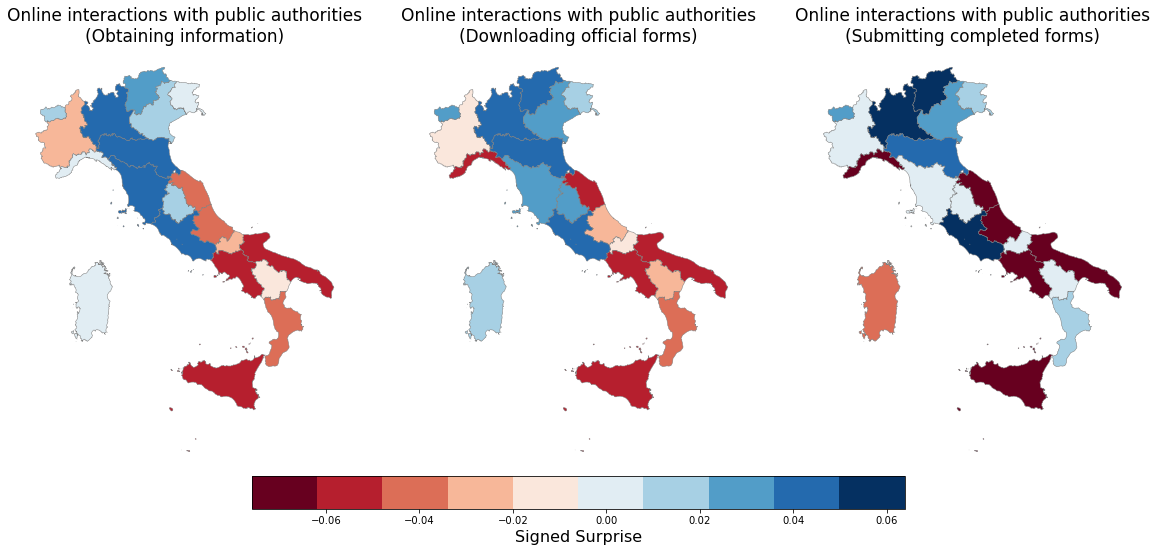

In [44]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})

# Merge the map with the pandas dfs
merged_1 = pd.merge(map_reg, surprise_df_1, left_on='DEN_REG', right_on='Territory', how='left')
merged_2 = pd.merge(map_reg, surprise_df_2, left_on='DEN_REG', right_on='Territory', how='left')
merged_3 = pd.merge(map_reg, surprise_df_3, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2018'
cmap = discrete_cmap(10, 'RdBu')
#max_abs_value_1 = max(np.abs(min(merged_1[YEAR])), np.abs(max(merged_1[YEAR])))
#max_abs_value_2 = max(np.abs(min(merged_2[YEAR])), np.abs(max(merged_2[YEAR])))
#max_abs_value_3 = max(np.abs(min(merged_3[YEAR])), np.abs(max(merged_3[YEAR])))
#max_value = max(max_abs_value_1, max_abs_value_2, max_abs_value_3)
max_value = max(max(merged_1[YEAR]), max(merged_2[YEAR]), max(merged_3[YEAR]))
min_value = min(min(merged_1[YEAR]), min(merged_2[YEAR]), min(merged_3[YEAR]))

fig, ax = plt.subplots(ncols=3, figsize=(20, 10))

ax[0].axis('off')
ax[0].set_title('Online interactions with public authorities\n(Obtaining information)', fontsize=17)
merged_1.plot(column=YEAR, vmin=min_value, vmax=max_value, cmap=cmap, linewidth=0.5, ax=ax[0], edgecolor='0.5')

ax[1].axis('off')
ax[1].set_title('Online interactions with public authorities\n(Downloading official forms)', fontsize=17)
merged_2.plot(column=YEAR, vmin=min_value, vmax=max_value, cmap=cmap, linewidth=0.5, ax=ax[1], edgecolor='0.5')

ax[2].axis('off')
ax[2].set_title('Online interactions with public authorities\n(Submitting completed forms)', fontsize=17)
merged_3.plot(column=YEAR, vmin=min_value, vmax=max_value, cmap=cmap, linewidth=0.5, ax=ax[2], edgecolor='0.5')

# Common colorbar
norm = colors.Normalize(vmin=min_value, vmax=max_value)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation="horizontal", fraction=0.06, pad=0.01)
cbar.set_label('Signed Surprise', fontsize=16)

In [45]:
fig.savefig('img/public_auth/surprise_demoivre.png', bbox_inches='tight')